In [316]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
pd.options.display.max_columns = None
import datetime

Meta notes:
 - Sample unbanlance
 - how to deal with features with intrinstic order in GBDT? e.g. consumption level, shop score - will the algo. automaticaly cut according to info gain?
 - Query & category match?

### Data Loading

In [317]:
# data from txt
train = pd.read_csv("/Users/riren/Desktop/ijcai/round1_ijcai_18_train_20180301.txt",sep=" ")
test = pd.read_csv("/Users/riren/Desktop/ijcai/round1_ijcai_18_test_a_20180301.txt",sep=" ")

In [318]:
y = train.pop('is_trade')

In [319]:
train.shape

(478138, 26)

In [320]:
test.shape

(18371, 26)

In [321]:
data = pd.concat([train, test])

In [322]:
data.head()

,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level,context_id,context_timestamp,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,1,1003,2005,3003,282924576738839389,1537236544,4006,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,0,1002,2005,3006,4007979028023783431,1537243232,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,0,1003,2005,3004,4884875192608989870,1537211052,4001,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,1,1004,2005,3006,840119421106178602,1537222670,4016,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0
4,7975697065017708072,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2729475788342039013,0,1002,2005,3001,1736769971710354684,1537271320,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0


### Feature Engineering

**基础数据**

In [323]:
basic = ['instance_id','item_id','user_id','context_id','shop_id']
data[basic].head()

,instance_id,item_id,user_id,context_id,shop_id
0,108641074714126964,3412720377098676069,4505772604969228686,282924576738839389,6765930309048922341
1,5754713551599725161,3412720377098676069,2692638157208937547,4007979028023783431,6765930309048922341
2,842679481291040981,3412720377098676069,5247924392014515924,4884875192608989870,6765930309048922341
3,937088850059189027,3412720377098676069,2681414445369714628,840119421106178602,6765930309048922341
4,7975697065017708072,3412720377098676069,2729475788342039013,1736769971710354684,6765930309048922341


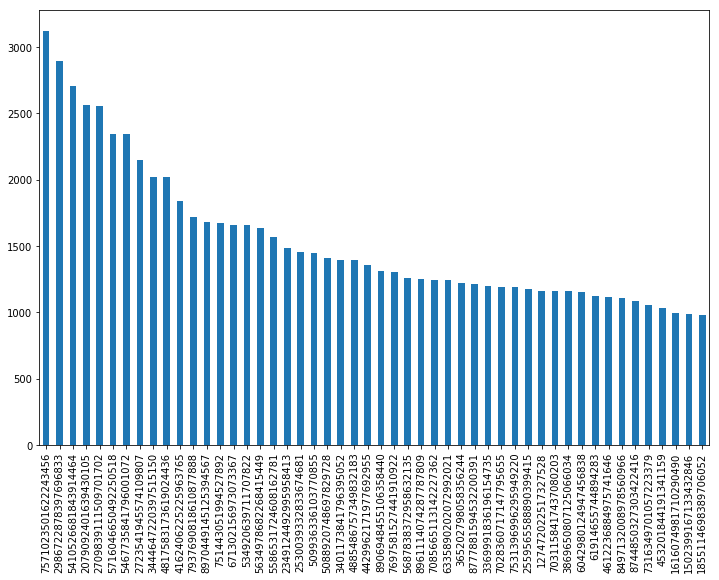

In [324]:
plt.figure(figsize=(12,8))
data.item_id.value_counts()[:50].plot(kind = 'bar')

In [325]:
# instance_id, context_id: drop | is_trade: pop | item_idm user_id, shop_id: label encoding
data = data.drop(['instance_id','context_id'],axis = 1)

In [326]:
lbl = preprocessing.LabelEncoder()
for col in ['item_id','user_id','shop_id']:
    data[col] = lbl.fit_transform(data[col])

In [327]:
data[['item_id','user_id','shop_id']].head()

,item_id,user_id,shop_id
0,3804,101412,2906
1,3804,60658,2906
2,3804,118063,2906
3,3804,60417,2906
4,3804,61521,2906


**广告商品信息**

In [328]:
ads = ['item_id','item_category_list','item_property_list','item_brand_id','item_city_id','item_price_level','item_sales_level','item_collected_level','item_pv_level']
data[ads].head()

,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level
0,3804,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14
1,3804,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14
2,3804,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14
3,3804,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14
4,3804,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14


In [329]:
# encode item_category_list
# Maximum depth of category hierachay
max_len_cate = max(data['item_category_list'].map(lambda x: x.split(';')).map(lambda x: len(x)))
max_len_cate

3

In [330]:
# label encode item category; i = 0,1,2
for i in range(max_len_cate):
    data['item_category_hierachay' + '_' + str(i)] = lbl.fit_transform(
        data['item_category_list'].map(lambda x: str(str(x).split(';')[i]) if len(str(x).split(';')) >= i+1 else ''))

In [331]:
data[['item_category_hierachay_0','item_category_hierachay_1','item_category_hierachay_2']].head()

,item_category_hierachay_0,item_category_hierachay_1,item_category_hierachay_2
0,0,9,0
1,0,9,0
2,0,9,0
3,0,9,0
4,0,9,0


In [332]:
# item_property_list
# Maximum # of property
max_len_prop = max(data['item_property_list'].map(lambda x: x.split(';')).map(lambda x: len(x)))
max_len_prop

100

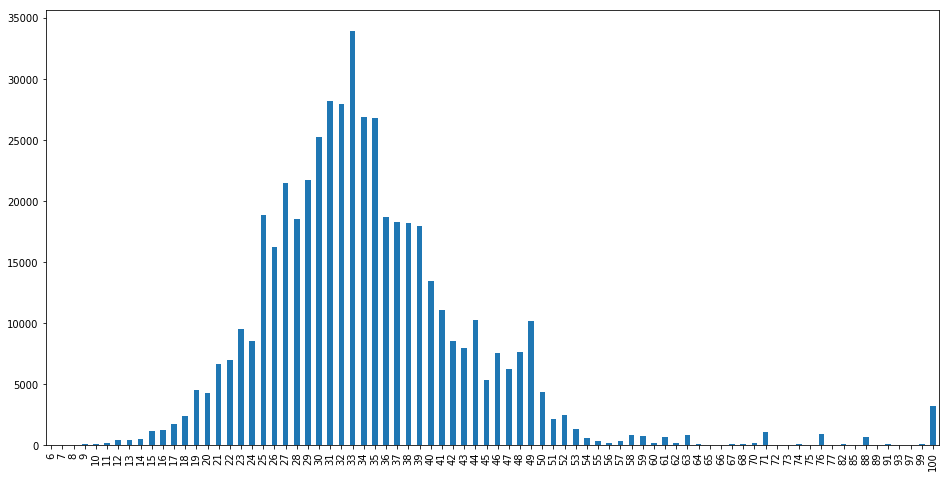

In [333]:
# seems too much properties, further see distribution
plt.figure(figsize=(16,8))
data['item_property_list'].map(lambda x: x.split(';')).map(lambda x: len(x)).value_counts().sort_index().plot(kind = 'bar')

*Mark: property # issue*

In [334]:
# let's try cut uplimit at 10
for i in range(10):
    data['item_property_list' + str(i)] = lbl.fit_transform(
        data['item_property_list'].map(lambda x: str(str(x).split(';')[i]) if len(str(x).split(';')) >= i+1 else ''))

In [335]:
lst = ['item_property_list' + str(i) for i in range(10)]
data[lst].head()

,item_property_list0,item_property_list1,item_property_list2,item_property_list3,item_property_list4,item_property_list5,item_property_list6,item_property_list7,item_property_list8,item_property_list9
0,27,66,41,228,259,404,224,87,898,834
1,27,66,41,228,259,404,224,87,898,834
2,27,66,41,228,259,404,224,87,898,834
3,27,66,41,228,259,404,224,87,898,834
4,27,66,41,228,259,404,224,87,898,834


In [336]:
# encode brand and city
for col in ['item_brand_id','item_city_id']:
    data[col] = lbl.fit_transform(data[col])

In [337]:
data[['item_brand_id','item_city_id']].head()

,item_brand_id,item_city_id
0,453,50
1,453,50
2,453,50
3,453,50
4,453,50


**用户信息**

In [338]:
# seems no much encoding needed.
usr = ['user_id','user_gender_id','user_age_level','user_occupation_id','user_star_level']
data[usr].head()

,user_id,user_gender_id,user_age_level,user_occupation_id,user_star_level
0,101412,1,1003,2005,3003
1,60658,0,1002,2005,3006
2,118063,0,1003,2005,3004
3,60417,1,1004,2005,3006
4,61521,0,1002,2005,3001


**店铺信息**

In [339]:
shop = ['shop_id','shop_review_num_level','shop_review_positive_rate','shop_star_level','shop_score_service','shop_score_delivery','shop_score_description']
data[shop].head()

,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description
0,2906,4,1.0,5002,1.0,1.0,1.0
1,2906,4,1.0,5002,1.0,1.0,1.0
2,2906,4,1.0,5002,1.0,1.0,1.0
3,2906,4,1.0,5002,1.0,1.0,1.0
4,2906,4,1.0,5002,1.0,1.0,1.0


*Caveat mark: numeric feature*

**上下文信息**

In [340]:
context = ['context_timestamp','context_page_id','predict_category_property']
data[context].head()

,context_timestamp,context_page_id,predict_category_property
0,1537236544,4006,5799347067982556520:-1;509660095530134768:-1;5...
1,1537243232,4001,5799347067982556520:9172976955054793469;790838...
2,1537211052,4001,5799347067982556520:5131280576272319091;725801...
3,1537222670,4016,509660095530134768:-1;5799347067982556520:-1;7...
4,1537271320,4001,5799347067982556520:9172976955054793469;790838...


In [341]:
# unix timestamp convert
print(
    datetime.datetime.fromtimestamp(
        int("1284101485")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2010-09-10 14:51:25


In [342]:
data['dt'] = data.context_timestamp.map(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [343]:
t = pd.DatetimeIndex(data.dt)
hr = t.hour
data['HourOfDay'] = hr
month = t.month
data['Month'] = month

In [344]:
data[['HourOfDay','Month','dt']].head()

,HourOfDay,Month,dt
0,10,9,2018-09-18 10:09:04
1,12,9,2018-09-18 12:00:32
2,3,9,2018-09-18 03:04:12
3,6,9,2018-09-18 06:17:50
4,19,9,2018-09-18 19:48:40


In [345]:
data['Month'].value_counts()

9    496509
Name: Month, dtype: int64

In [346]:
data = data.drop(['Month','dt','context_timestamp'],axis = 1)

In [347]:
def map_hour(x):
    
    if (x >= 7)&(x <= 12):
        return 1 # morning
    elif (x >= 13)&(x <= 18):
        return 2 # afternoon
    elif (x >= 19)&(x <= 23):
        return 3 # evening
    else:
        return 4 # late night

In [348]:
data['time'] = data['HourOfDay'].map(lambda x: map_hour(x))

In [349]:
data = data.drop(['HourOfDay'],axis = 1)

In [350]:
data['time'].head()

0    1
1    1
2    4
3    4
4    3
Name: time, dtype: int64

In [351]:
data['context_page_id'].value_counts()

4001    277687
4002     45461
4003     32661
4004     24991
4005     19579
4006     15725
4007     12848
4008     10783
4009      9328
4010      7754
4011      6630
4012      6033
4013      5078
4014      4405
4015      3961
4016      3498
4017      3110
4018      2624
4019      2331
4020      2022
Name: context_page_id, dtype: int64

*match cate/property prediction with actual*

In [352]:
data['predict_category_property_list'] = data['predict_category_property'].map(lambda x: x.split(';'))

In [353]:
data['predict_category_list'] = data['predict_category_property_list'].map(lambda x: [element.split(':')[0] for element in x])

In [354]:
# Maximum depth of category prediction
max_len_predict_cate = max(data['predict_category_list'].map(lambda x: len(x)))
max_len_predict_cate

14

In [355]:
data['predict_category_list'].map(lambda x: len(x)).value_counts().sort_index()

1       1543
2      50697
3      72153
4     101753
5     101169
6      81863
7      53305
8      19071
9      10643
10      4121
11       140
12        32
13        18
14         1
Name: predict_category_list, dtype: int64

In [356]:
data['predict_category_list'].head()

0    [5799347067982556520, 509660095530134768, 5755...
1           [5799347067982556520, 7908382889764677758]
2    [5799347067982556520, 7258015885215914736, 790...
3    [509660095530134768, 5799347067982556520, 7908...
4           [5799347067982556520, 7908382889764677758]
Name: predict_category_list, dtype: object

In [357]:
data['item_category_list'] = data['item_category_list'].map(lambda x:x.split(";"))

In [377]:
data['item_category_list'].head()

0    [7908382889764677758, 5799347067982556520]
1    [7908382889764677758, 5799347067982556520]
2    [7908382889764677758, 5799347067982556520]
3    [7908382889764677758, 5799347067982556520]
4    [7908382889764677758, 5799347067982556520]
Name: item_category_list, dtype: object

In [359]:
#how many % of cate predicted in query matched actual
def intersection (listA,listB):
    try:
        inter_score = len([i for i in listB if i in listA])/len(listB)
    except:
        inter_score = 0
    return inter_score

In [374]:
data['cate_predict_precision'] = data.apply(lambda row: intersection(row['item_category_list'], row['predict_category_list']), axis=1)

In [375]:
data['cate_predict_precision'].head()

0    0.400000
1    1.000000
2    0.666667
3    0.400000
4    1.000000
Name: cate_predict_precision, dtype: float64

In [362]:
# deal with prop
temp = data['predict_category_property_list'].map(lambda x: [element.split(':')[1:] for element in x])
data['predict_prop_list'] = temp.map(lambda row: list(set([item for sublist in row for item in sublist])))

In [363]:
data['predict_prop_list'].head()

0                            [9148482949976129397, -1]
1    [9172976955054793469, 1787573075717641245,9172...
2                                [5131280576272319091]
3    [9148482949976129397, 1787573075717641245,9148...
4                                [9172976955054793469]
Name: predict_prop_list, dtype: object

In [364]:
data['item_property_list'].head()

0    2072967855524022579;5131280576272319091;263639...
1    2072967855524022579;5131280576272319091;263639...
2    2072967855524022579;5131280576272319091;263639...
3    2072967855524022579;5131280576272319091;263639...
4    2072967855524022579;5131280576272319091;263639...
Name: item_property_list, dtype: object

In [365]:
data['item_property_list'] = data['item_property_list'].map(lambda x:x.split(";"))

In [369]:
data['item_property_list'].head()

0    [2072967855524022579, 5131280576272319091, 263...
1    [2072967855524022579, 5131280576272319091, 263...
2    [2072967855524022579, 5131280576272319091, 263...
3    [2072967855524022579, 5131280576272319091, 263...
4    [2072967855524022579, 5131280576272319091, 263...
Name: item_property_list, dtype: object

In [370]:
data['prop_predict_precision'] = data.apply(lambda row: intersection`(row['item_property_list'], row['predict_prop_list']), axis=1)

In [373]:
data['prop_predict_precision'].head()

0    0.0
1    0.5
2    1.0
3    0.0
4    1.0
Name: prop_predict_precision, dtype: float64

In [ ]:
data.colums

In [ ]:
cols = []